# Cleaning

In [1]:
# Importing necessary modules
import seaborn as sns
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
import numpy as np
import re
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType, FloatType
from pyspark.sql.functions import *
import random
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
import time

# Setting up visualization
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
cols_to_keep = [
    "Voters_Gender", # cat
    "Voters_Age", # num
    "Voters_BirthDate", # ignore
    "Residence_Families_HHCount", # num
    "Residence_HHGender_Description", # cat
    "Mailing_Families_HHCount", # num
    "Mailing_HHGender_Description", # cat

#   !! voter party affiliation
    "Parties_Description", 
    
    # cat
    "CommercialData_PropertyType",
    "AddressDistricts_Change_Changed_CD",
    "AddressDistricts_Change_Changed_SD",
    "AddressDistricts_Change_Changed_HD",
    "AddressDistricts_Change_Changed_County",
    
    "Residence_Addresses_Density", # num
    
    # cat
    "CommercialData_EstimatedHHIncome",
    "CommercialData_ISPSA",
    # num
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue",
#    "CommercialData_MosaicZ4Global",
    # cat
     "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren",
     "CommercialData_StateIncomeDecile",
#    "Ethnic_Description",
    "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_DwellingType",
    "CommercialData_PresenceOfChildrenCode",
#    "CommercialData_PresenceOfPremCredCrdInHome", ## too many missing
    "CommercialData_DonatesToCharityInHome",
    "CommercialData_DwellingUnitSize",
    "CommercialData_ComputerOwnerInHome",
    "CommercialData_DonatesEnvironmentCauseInHome",
    "CommercialData_Education",
    
#   Don't include because of lookahead bias  
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Voters_VotingPerformanceEvenYearPrimary",
#     "Voters_VotingPerformanceEvenYearGeneralAndPrimary",
#     "Voters_VotingPerformanceMinorElection",
    
#   Other control variables that expect to be highly associated with outcome:
#     "ElectionReturns_P08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_P08CountyTurnoutDemocrats",
#     "ElectionReturns_P08CountyTurnoutRepublicans",
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004",
        
#   Outcome variable (indiana law happens in 2005, approved by SCOTUS before presidential election in 2008)
    "General_2008"
]

In [3]:
pct = [
    "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren"
]
    
numeric_cols = [
    'Voters_Age',
    'Residence_Families_HHCount',
    'Mailing_Families_HHCount',
    'Residence_Addresses_Density',
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue"
] + pct

trinary_cols = [
    'CommercialData_DonatesToCharityInHome',
    'CommercialData_ComputerOwnerInHome',
    'CommercialData_DonatesEnvironmentCauseInHome'
]

dont_touch_cols = [
    "General_2008", 
    "Voters_BirthDate", 
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004"
]

cols_excluded_from_regression = [
    'STATE',
    'General_2008'
]

categorical_cols = [c for c in cols_to_keep if c not in (dont_touch_cols+numeric_cols+cols_excluded_from_regression)]
#other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols)]

In [4]:
# These are the states that do not have strict voter ID laws:
#  'VM2Uniform--CA--2021-05-02',	VM2Uniform--CA--2021-05-02	CA	x	California
#  'VM2Uniform--IL--2021-03-05',	VM2Uniform--IL--2021-03-05	IL	x	Illinois
#  'VM2Uniform--MA--2021-01-19',	VM2Uniform--MA--2021-01-19	MA	x	Massachusetts
#  'VM2Uniform--MD--2021-02-15',	VM2Uniform--MD--2021-02-15	MD	x	Maryland
#  'VM2Uniform--ME--2021-05-28',	VM2Uniform--ME--2021-05-28	ME	x	Maine
#  'VM2Uniform--MN--2021-02-14',	VM2Uniform--MN--2021-02-14	MN	x	Minnesota
#  'VM2Uniform--NC--2021-05-18',	VM2Uniform--NC--2021-05-18	NC	x	North Carolina
#  'VM2Uniform--NE--2021-01-20',	VM2Uniform--NE--2021-01-20	NE	x	Nebraska
#  'VM2Uniform--NJ--2021-03-11',	VM2Uniform--NJ--2021-03-11	NJ	x	New Jersey
#  'VM2Uniform--NM--2021-02-25',	VM2Uniform--NM--2021-02-25	NM	x	New Mexico
#  'VM2Uniform--NV--2021-06-13',	VM2Uniform--NV--2021-06-13	NV	x	Nevada
#  'VM2Uniform--NY--2021-03-15',	VM2Uniform--NY--2021-03-15	NY	x	New York
#  'VM2Uniform--OR--2021-02-05',	VM2Uniform--OR--2021-02-05	OR	x	Oregon
#  'VM2Uniform--PA--2021-05-20',	VM2Uniform--PA--2021-05-20	PA	x	Pennsylvania
#  'VM2Uniform--VT--2021-05-28',	VM2Uniform--VT--2021-05-28	VT	x	Vermont

# For each of these states, I want to pull enough samples to get a total sample of 1/2 M; can increase later

# grab files
states =  [
# For now, just exclude New York and Califonria, because the parquet files take too long to read
'VM2Uniform--VT--2021-05-28', 
'VM2Uniform--IL--2021-03-05',
'VM2Uniform--MA--2021-01-19',
'VM2Uniform--MD--2021-02-15',
'VM2Uniform--ME--2021-05-28',
'VM2Uniform--MN--2021-02-14',
'VM2Uniform--NC--2021-05-18',
'VM2Uniform--NE--2021-01-20',
'VM2Uniform--NJ--2021-03-11',
'VM2Uniform--NM--2021-02-25',
'VM2Uniform--NV--2021-06-13',
'VM2Uniform--OR--2021-02-05',
'VM2Uniform--PA--2021-05-20',
'VM2Uniform--CA--2021-05-02',
'VM2Uniform--NY--2021-03-15',
'VM2Uniform--IN--2021-01-15'
]

# bucket file path for all state parquet files
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

# create list of state abbreviations
pattern = re.compile(r"(?<=--)[A-Z]{2}")
state_abvs = re.findall(pattern, ''.join(states))

# do first iteration
print('VM2Uniform--VT--2021-05-28')

# num_per_state = 500

df_ref = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--VT--2021-05-28']))
df_ref = df_ref.select(cols_to_keep)

numrows = {'VM2Uniform--VT--2021-05-28': df_ref.count()}

print("%d" % (numrows['VM2Uniform--VT--2021-05-28']))
    
percentage_sample = 0.001 #num_per_state / numrows['VM2Uniform--VT--2021-05-28']
    
df_ref = df_ref.sample(True, percentage_sample, seed = 19480384)
df_ref = df_ref.withColumn('STATE', F.lit(state_abvs[0]))
 
next_states = states[1:]

# do the rest of the iterations
for i, one_state in enumerate(next_states):

    print("%s: " % (one_state), end="")
    
    # read dataframe for one_state
    tmp_ref = spark.read.parquet("/".join([gcs_path, one_state]))
    tmp_ref = tmp_ref.select(cols_to_keep)
    numrows[one_state] = tmp_ref.count()
    print("%d" % (numrows[one_state]))
    
#     percentage_sample = num_per_state / numrows[one_state]
    
    tmp_ref = tmp_ref.sample(True, percentage_sample, seed = 19480384)
    tmp_ref = tmp_ref.withColumn('STATE', F.lit(state_abvs[i+1]))
    
    df_ref = df_ref.union(tmp_ref)      

df_ref.printSchema()
df_ref.count()

VM2Uniform--VT--2021-05-28


463261
VM2Uniform--IL--2021-03-05: 

8336875
VM2Uniform--MA--2021-01-19: 

4572639
VM2Uniform--MD--2021-02-15: 

4110570
VM2Uniform--ME--2021-05-28: 

1040452
VM2Uniform--MN--2021-02-14: 

3563623
VM2Uniform--NC--2021-05-18: 

6616158
VM2Uniform--NE--2021-01-20: 

1201308
VM2Uniform--NJ--2021-03-11: 

6109844
VM2Uniform--NM--2021-02-25: 

1205712
VM2Uniform--NV--2021-06-13: 

1866442
VM2Uniform--OR--2021-02-05: 

3166785
VM2Uniform--PA--2021-05-20: 

8359764
VM2Uniform--CA--2021-05-02: 

21779518
VM2Uniform--NY--2021-03-15: 

12570650
VM2Uniform--IN--2021-01-15: 

4396576
root
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_BirthDate: string (nullable = true)
 |-- Residence_Families_HHCount: string (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = true)
 |-- Mailing_Families_HHCount: string (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_PropertyType: string (nullable = true)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_County: string (nullable = true)
 |-- Residence_Addresses_Density: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_ISPSA: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: string (nullable 

87692

### FUNCTIONS TO CLEAN DATASET

In [5]:
def clean_voter_participation(input_df: DataFrame) -> DataFrame:

    yrs_add = 18
    months_add = 18*12

    # date of national 
    target_month_day_presidential = "11-03"

    # date of presidential primary (ideally we should do this state by state, but this is the date for Indiana's)
    target_month_day_primary = "05-03" 

    input_df = input_df.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate"),"MM/dd/yyyy"), months_add))
    input_df.select(["Voters_BirthDate", "DATE_18"]).show(10)
    input_df = input_df.dropna(subset = "Voters_BirthDate")
    input_df = input_df.withColumn("YEAR_18", year("DATE_18"))
    input_df = input_df.withColumn("comparator_date_presidential", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_presidential))))
    input_df = input_df.withColumn("comparator_date_primary", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_primary))))

    for election in ["PRESIDENTIAL", "PRIMARY"]:
        input_df = input_df.withColumn(f"YEAR_ELIGIBLE_TO_VOTE_{election}", \
                                    when(col("DATE_18")<=col(f"comparator_date_{election.lower()}"), col("YEAR_18")) \
                                   .otherwise(col("YEAR_18") + 1) \
                                  )

    # check no missing vals:
    input_df.where(col("YEAR_18").isNull()).select("YEAR_18").show(10)

    # get rid of rows where the voter was not old enough to vote in the 2008 general election
    input_df = input_df.filter(col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<=2008).fillna("N", subset = ["General_2008"])

    # for the 2000 and 2004 general elections, replace with "N" IF the person was old enough to vote at the time

    for election in ["2000", "2004"]:
        input_df = input_df.withColumn(f"General_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<= int(election)) & \
                                        (col(f"General_{election}").isNull()), "N") \
                                   .otherwise(col(f"General_{election}")) \
                                  )

        input_df = input_df.withColumn(f"PresidentialPrimary_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRIMARY")<= int(election)) & \
                                        (col(f"PresidentialPrimary_{election}").isNull()), "N") \
                                   .otherwise(col(f"PresidentialPrimary_{election}")) \
                                  )

    # make the general voting for 2008 a numeric variable; since we've deleted
    # everyone who was not eligible to vote, this can be directly calculated with a 1-0.
    input_df = input_df.withColumn("Voted_General_2008", when(input_df.General_2008 == "Y",1).otherwise(0))
    input_df = input_df.withColumn("General_2008", F.col("Voted_General_2008"))
    
    elec_cols = ["General_2000", "General_2004", "PresidentialPrimary_2000", "PresidentialPrimary_2004"]
    input_df = input_df.fillna("Unknown", subset=elec_cols)
    
    to_drop = [
        'Voters_BirthDate', # removed this, but KEPT the YEAR that the voter turned 18.
        'DATE_18',
        'YEAR_18',
        'comparator_date_presidential',
        'comparator_date_primary',
        'YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL',
        'YEAR_ELIGIBLE_TO_VOTE_PRIMARY',
        'Voted_General_2008'
    ]
    input_df = input_df.drop(*to_drop)
    
    return input_df

In [6]:
def clean_numeric_categorical(input_df: DataFrame) -> DataFrame:
    
    # remove special symbols ($, %) from relevant columns
    input_df = input_df.withColumn(
        "CommercialData_AreaMedianHousingValue",
        F.expr("substring(CommercialData_AreaMedianHousingValue, 2, length(CommercialData_AreaMedianHousingValue))"))

    for c in pct:
        input_df = input_df.withColumn(
            c,
            F.expr(f"substring({c}, 1, length({c})-1)")
        )
    input_df.select(["CommercialData_AreaMedianHousingValue"]+pct).show()


    for c in numeric_cols:
        input_df = input_df.withColumn(c, F.col(c).cast("float").alias(c))
#     input_df = input_df.fillna("U", subset= trinary_cols)
#     input_df = input_df.fillna("Missing", subset = other_cols)
#   input_df = input_df.fillna("N", subset = binary_cols)
    
    return input_df

In [7]:
def impute_numeric_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    # Impute the missing values in the numerical columns with the mean -- minimize change to z-scores of given data
    imputer = Imputer(
        inputCols=numeric_cols, 
        outputCols=numeric_cols
    )

    input_df = imputer.fit(input_df).transform(input_df)
    
    return input_df

In [8]:
def impute_categorical_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    input_df = input_df.withColumn("CommercialData_ISPSA", F.col("CommercialData_ISPSA").cast('string'))
    input_df = input_df.withColumn("CommercialData_StateIncomeDecile",
                                   F.col("CommercialData_StateIncomeDecile").cast('string'))
    
    input_df = input_df.fillna("U", subset= trinary_cols)
    input_df = input_df.fillna("Unknown", subset = categorical_cols)
    
    return input_df

In [11]:
# indi = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
# indi = indi.sample(True, 0.1, seed = 19480384)
# indi = indi.select(cols_to_keep)
#indi = indi.withColumn("STATE", lit("IN"))

In [ ]:
# indi = clean_voter_participation(indi)
# indi = clean_numeric_categorical(indi)
# indi = impute_numeric_values_function(indi)
# indi = impute_categorical_values_function(indi)
# indi.printSchema()

In [9]:
df_ref = clean_voter_participation(df_ref)
df_ref = clean_numeric_categorical(df_ref)
df_ref = impute_numeric_values_function(df_ref)
df_ref = impute_categorical_values_function(df_ref)
df_ref.printSchema()

+----------------+----------+
|Voters_BirthDate|   DATE_18|
+----------------+----------+
|      01/01/1996|2014-01-01|
|      01/01/1982|2000-01-01|
|      01/01/1988|2006-01-01|
|      06/25/1964|1982-06-25|
|      03/05/1991|2009-03-05|
|      11/01/1955|1973-11-01|
|      01/01/1986|2004-01-01|
|      01/01/2000|2018-01-01|
|      01/01/1989|2007-01-01|
|      01/01/1948|1966-01-01|
+----------------+----------+
only showing top 10 rows



+-------+
|YEAR_18|
+-------+
+-------+

+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|CommercialData_AreaMedianHousingValue|CommercialData_AreaPcntHHMarriedCoupleNoChild|CommercialData_AreaPcntHHMarriedCoupleWithChild|CommercialData_AreaPcntHHSpanishSpeaking|CommercialData_AreaPcntHHWithChildren|
+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|                               213709|                                           31|                                             18|                                       2|                                   28|
|                               180356|                                           43|                      

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: string (nullable = false)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [ ]:
df_ref.cache()
df_ref.count()

# Estimator with logistic regression index model

In [ ]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="General_2008 ~ . - STATE")

new_df = (
    df_ref.alias('new_df')
    #.select([c for c in df_ref.columns if c != 'STATE'])
    .withColumn('General_2008', F.col('General_2008').cast('float').alias('General_2008'))
)

fittedRF = supervised.fit(new_df)

preparedDF = fittedRF.transform(new_df)

preparedDF.select("features").show(n=10, truncate = False)

indi = preparedDF.filter(F.col('STATE') == 'IN') 
not_indi = preparedDF.filter(F.col('STATE') != 'IN') 

In [23]:
train, test = not_indi.randomSplit([0.7, 0.3], seed = 42069)
train.count()

23/03/20 21:55:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1692.7 KiB


6677

23/03/21 00:51:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1971.0 KiB
23/03/21 00:51:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1972.1 KiB
23/03/21 00:51:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1972.4 KiB
23/03/21 00:51:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1973.5 KiB
23/03/21 00:51:52 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 00:51:52 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/21 00:51:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1972.4 KiB
23/03/21 00:51:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1973.5 KiB
23/03/21 00:51:53 WARN org.apache.spark.sch

Text(0, 0.5, 'Beta Coefficients')

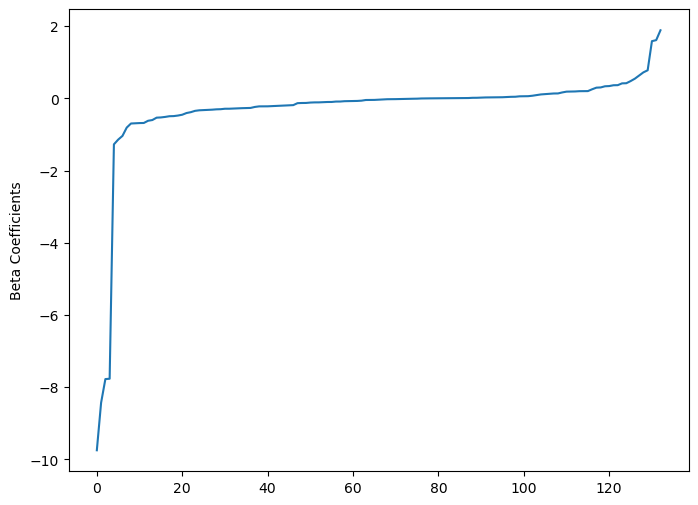

In [15]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

lrModel = lr.fit(train)

featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

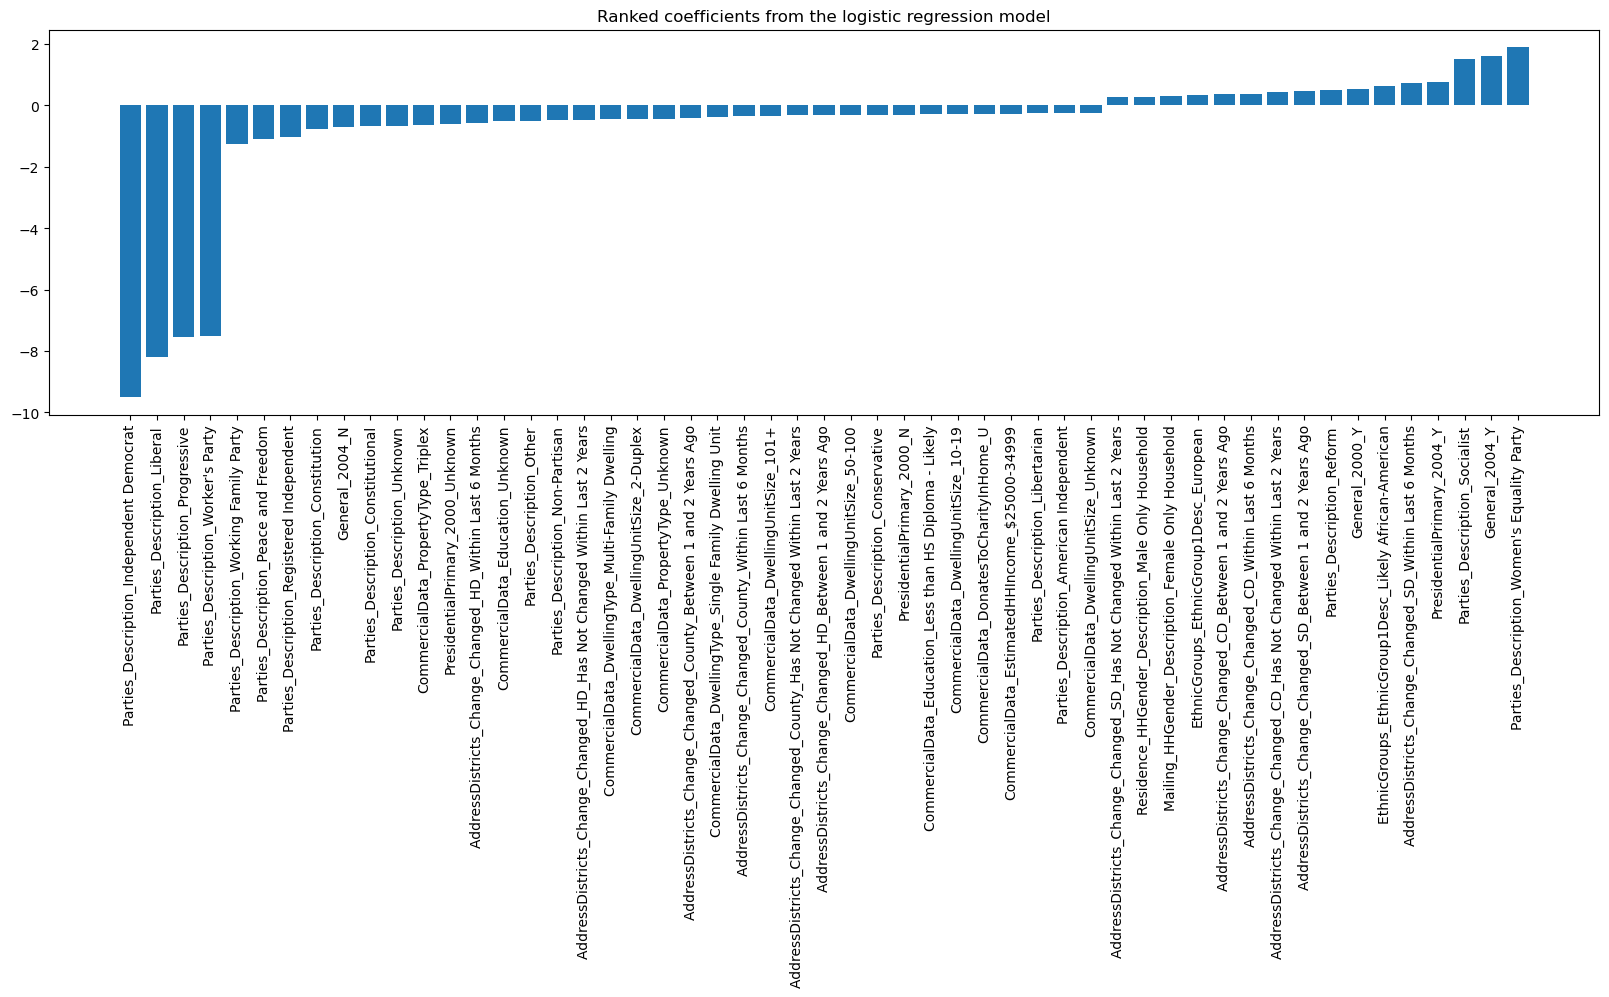

In [27]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
cols = ['coefs']
coefsDF[cols] = coefsDF[coefsDF[cols].abs() > 0.25][cols]
coefsDF.dropna(inplace = True)
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

plt.rcParams["figure.figsize"] = (20,5)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [28]:
summary = lrModel.summary
print(summary.areaUnderROC)

23/03/20 22:02:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1986.7 KiB


0.8639516062711261


In [29]:
fittedTest = lrModel.transform(test)
fittedTest.groupBy("label", "prediction").count().show()

23/03/20 22:02:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1991.0 KiB
23/03/20 22:02:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1879.8 KiB
23/03/20 22:03:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1879.8 KiB


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 9145|
|  0.0|       1.0| 1402|
|  1.0|       0.0| 2730|
|  0.0|       0.0| 6625|
+-----+----------+-----+



In [20]:
fittedTest.select("label","prediction","rawPrediction").show(n=10)

+-----+----------+--------------------+
|label|prediction|       rawPrediction|
+-----+----------+--------------------+
|  1.0|       1.0|[-0.0203966844236...|
|  1.0|       0.0|[0.51946504505927...|
|  1.0|       0.0|[0.30767492160166...|
|  1.0|       1.0|[-0.2949073416146...|
|  1.0|       1.0|[-0.2399285689857...|
|  0.0|       1.0|[-0.6234106536570...|
|  1.0|       1.0|[-0.1810302569730...|
|  0.0|       0.0|[1.13461076846161...|
|  1.0|       0.0|[1.73096507308387...|
|  0.0|       0.0|[1.72660078499870...|
+-----+----------+--------------------+
only showing top 10 rows



In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator()
print(aucEvaluator.evaluate(fittedTest,{aucEvaluator.metricName: "areaUnderROC"}))

23/03/20 22:03:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1983.2 KiB


0.8619433359779171


In [ ]:
# new_indi_df = (
#     indi.alias('new_indi_df')
#     .select([c for c in indi.columns if c != 'STATE'])
#     .withColumn('General_2008', F.col('General_2008').cast('float').alias('General_2008'))
# )

fittedRF_indi = supervised.fit(indi)

preparedDF_indi = fittedRF_indi.transform(indi)

preparedDF_indi.select("features").show(n=10, truncate = False)

#train, test = preparedDF_indi.randomSplit([0.7, 0.3], seed = 42069)

In [32]:
fittedTest_indi = lrModel.transform(indi)
fittedTest_indi.groupBy("label", "prediction").count().show()

23/03/20 22:04:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1961.5 KiB


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1520|
|  0.0|       1.0|  266|
|  1.0|       0.0|  465|
|  0.0|       0.0| 1171|
+-----+----------+-----+



23/03/20 22:04:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1864.7 KiB
23/03/20 22:04:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1864.7 KiB


In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator()
print(aucEvaluator.evaluate(fittedTest_indi,{aucEvaluator.metricName: "areaUnderROC"}))

23/03/20 22:05:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1953.7 KiB


0.8603434947913108


# Propensity score estimator

In [ ]:
num_voters_indiana = indi.count()
num_voters_not_indiana = df_ref.count()
pct_sample = num_voters_indiana / num_voters_not_indiana

# empty list to store the estimated average treatment effects:
ATEs = []

# empty dictionary to store output
stored_DF = {}

# start_time = time.time()

for i in range(1):
    i = i + 1 # from 1 - 100 rather than 0 to 100
    
    print(f"iteration {i}")

    # take random sample of the total parquet file (equivalent to the size of indiana)
    df_ref_sampled = df_ref.sample(True, pct_sample, seed = i)

    # create dummy DATA:
#     indi = indi.withColumn('Voters_Age', rand())
#     df_ref = df_ref.withColumn('Voters_Age', rand())
    
#     indi = indi.select(["Voters_Age"])
#     df_ref = df_ref.select(["Voters_Age"])

#     indi = indi.withColumn('Voters_Age', col('Voters_Age').cast('double'))
#     df_ref = df_ref.withColumn('Voters_Age', col('Voters_Age').cast('double'))

#     indi = indi.withColumn('General_2008_RANDOM', when(rand() > 0.5, 1).otherwise(0))
#     df_ref = df_ref.withColumn('General_2008_RANDOM', when(rand() > 0.5, 1).otherwise(0))

    # create a column with "LAW == 0" for non-Indiana states
    df_ref_sampled = df_ref_sampled.withColumn("LAW", lit(0))

    # create a column with "LAW == 1" for Indiana
    indi = indi.withColumn("LAW", lit(1))

    # union the two together
    df = df_ref_sampled.union(indi)

    cols_excluded_from_regression = [
        'Voters_BirthDate', # removed this, but KEPT the YEAR that the voter turned 18.
        'STATE',
        'STATE_ind',
        'DATE_18',
        'comparator_date_presidential',
        'comparator_date_primary',
        'YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL',
        'YEAR_ELIGIBLE_TO_VOTE_PRIMARY',
        'Voted_General_2008'
    ]
    
    df_input_logistic = df.drop(*cols_excluded_from_regression)

    # fit logistic model on the intervention (variable Law)
    nrow_df_input_logistic_start_check = df_input_logistic.count()
#     df_input_logistic = df_input_logistic.fillna(0)
    df_input_logistic.columns
    supervised = RFormula(formula="LAW ~ .")
    fittedRF = supervised.fit(df_input_logistic) # inspect column types
    prepareddf_input_logistic = fittedRF.transform(df_input_logistic) # create feature and label columns
    prepareddf_input_logistic.show(5, truncate = False)
    lr = LogisticRegression(labelCol="label",featuresCol="features")
    print(lr.explainParams())
    lrModel = lr.fit(prepareddf_input_logistic) # train model
    lrModel.transform(prepareddf_input_logistic).select("label", "prediction") # fitted values

    # get a propensity score from the probability as a new column:
    fitted = lrModel.transform(prepareddf_input_logistic)
    fitted = fitted.withColumn('probability', vector_to_array('probability'))
    array_mean = udf(lambda x: float(np.mean(x)), FloatType())
    fitted = fitted.withColumn("propensity_score", array_mean("probability"))
    try:
        assert fitted.count() == nrow_df_input_logistic_start_check
    except:
        Exception("before and after don't have same number of columns")

    # new column that called weight that is T - PS / (PS * 1 - PS)
    fitted = fitted.withColumn("weight", (col("label") - col("propensity_score")) / (col("propensity_score") * (1-col("propensity_score"))))

    # merge back in the 2008 general election OUTCOME data
    fitted = fitted.withColumn("row_id", monotonically_increasing_id())
    df = df.withColumn("row_id", monotonically_increasing_id())
    num_row_df_prior = df.count()
    df = df.join(fitted, ["row_id", "Voters_Age", "LAW"]).drop("row_id")
    
    try:
        assert num_row_df_prior == df.count()
    except:
        Exception("before and after don't have same number of columns")

    # calculate the weighted average
    df = df.withColumn("weighted_outcome", col("General_2008_RANDOM") * col("weight"))

    # store weighted average into list
    ATE_this_round = df.agg(avg(col("weighted_outcome"))).collect()[0][0]
    ATEs.append(ATE_this_round)

    # store the DataFrame into a dictionary
    stored_DF[f"{i}"] = df
    
# end_time = time.time()
# print("Execution time: {:.2f} seconds".format(end_time - start_time))

In [ ]:
df.show(10)

In [ ]:
ATEs

In [ ]:
range(1)

In [ ]:
start_time = time.time()
end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Doubly Robust Estimator

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
# preparedDF from first LR model -- has features of all variables except General_2008 and STATE
#train, test = preparedDF.randomSplit([0.7, 0.3], seed = 42069)
# lrModel from other section, trained on other state data, predict on other state + indiana
mu0model = lr.fit(not_indi).transform(preparedDF)
mu0 = mu0model.select("probability")
# train the model on indiana data, predict on other state + indiana
mu1model = lr.fit(indi).transform(preparedDF)
mu1 = mu1model.select("probability")
# change label column from General_2008 data to Treatment indicator
train_new = preparedDF.withColumnRenamed("label", "label_old")
train_new = train_new.withColumn('label', F.when(F.col('STATE') == 'IN', 1.0).otherwise(0.0))
# train model on other state + indiana, predict on other state + indiana
psmodel = lr.fit(train_new).transform(train_new)
ps = psmodel.select("probability")

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# since there is no common column between these two dataframes add row_index so that it can be joined
train_new=train_new.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
mu1=mu1.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'mu1')
mu0=mu0.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'mu0')
ps=ps.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'ps')

train_new = train_new.join(mu1, on=["row_index"])\
.join(mu0, on=["row_index"])\
.join(ps, on=["row_index"])\
.drop("row_index")

train_new.select("mu0", "mu1", "ps", "label", "label_old").show(truncate = False)

In [20]:
train_new.select("mu0", "mu1", "ps", "label", "label_old").show(truncate = False)

23/03/21 05:36:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:36:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:36:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:36:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:36:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1692.1 KiB
23/03/21 05:36:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+----------------------------------------+-----------------------------------------+-----------------------------------------+-----+---------+
|mu0                                     |mu1                                      |ps                                       |label|label_old|
+----------------------------------------+-----------------------------------------+-----------------------------------------+-----+---------+
|[0.7364739477220829,0.26352605227791714]|[0.7063084235739244,0.2936915764260756]  |[0.9917626154690324,0.008237384530967562]|0.0  |0.0      |
|[0.6999208362762893,0.3000791637237107] |[0.5061681091928909,0.4938318908071091]  |[0.9534081748449641,0.046591825155035904]|0.0  |1.0      |
|[0.4276407655288278,0.5723592344711722] |[0.33530220863868265,0.6646977913613173] |[0.9929318856830979,0.00706811431690213] |0.0  |1.0      |
|[0.6209611152313642,0.3790388847686358] |[0.5570755225370461,0.44292447746295394] |[0.9565662116095296,0.04343378839047041] |0.0  |1.0      |

In [21]:
from pyspark.sql.types import FloatType
secondelement=F.udf(lambda v:float(v[1]),FloatType())

train_new = train_new.withColumn("mu0", secondelement("mu0"))
train_new = train_new.withColumn("mu1", secondelement("mu1"))
train_new = train_new.withColumn("ps", secondelement("ps"))

train_new.select("mu0", "mu1", "ps", "label", "label_old").show(truncate = False)

23/03/21 05:44:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:44:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:44:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:44:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:44:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1692.1 KiB
23/03/21 05:44:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+----------+----------+------------+-----+---------+
|mu0       |mu1       |ps          |label|label_old|
+----------+----------+------------+-----+---------+
|0.26352605|0.29369158|0.008237384 |0.0  |0.0      |
|0.30007917|0.4938319 |0.046591826 |0.0  |1.0      |
|0.57235926|0.66469777|0.0070681144|0.0  |1.0      |
|0.37903887|0.44292447|0.04343379  |0.0  |1.0      |
|0.16955242|0.08971085|0.038404852 |0.0  |0.0      |
|0.27681905|0.20420086|0.13008662  |0.0  |0.0      |
|0.95370185|0.9465604 |0.06739985  |0.0  |1.0      |
|0.2373803 |0.23963079|0.08868021  |0.0  |0.0      |
|0.9282854 |0.91244805|0.03424732  |0.0  |1.0      |
|0.43228257|0.60307664|0.041610084 |0.0  |0.0      |
|0.8398582 |0.9236555 |0.010732992 |0.0  |1.0      |
|0.34446922|0.4757234 |0.035851676 |0.0  |0.0      |
|0.16678195|0.33415538|0.056813713 |0.0  |0.0      |
|0.27963978|0.5211771 |0.044143647 |0.0  |0.0      |
|0.5972794 |0.7259028 |0.02347001  |0.0  |0.0      |
|0.90560985|0.936997  |0.01437821  |0.0  |1.0 

In [24]:
## I think this might actually be right based off of Logistic Regression output
# It seems pyspark does it so probability ~ 1 --> predict 0, so backwards
tmp = train_new.select(
    F.expr("mean(label * (label_old - (1-mu1))/(1-ps) + (1-mu1))").alias("first_term"),
    F.expr("mean((1-label) * (label_old - (1-mu0))/ps + (1-mu0))").alias("second_term")
)
tmp.withColumn("doubly_robust", F.col('first_term') - F.col('second_term')).select("doubly_robust").show()

23/03/21 05:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 05:55:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1692.1 KiB
23/03/21 05:55:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+--------------------+
|       doubly_robust|
+--------------------+
|-1.11776794925547...|
+--------------------+

